#**Statistical validation tests: gauges, CHIRPS and IMERG.**

Script used for statistical validation tests of daily rainfall data from gauges, CHIRPS and IMERG.

Area of Study: The Paraiba's Valley and North Coast of the Sao Paulo state, Brazil.

Time series: from 2000-06-01 to 2018-12-31.



## Mount drive for accessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing and importing libs

In [ ]:
!pip install hydrobr  # for the brazilian rainfall data network 
import hydrobr

!pip install HydroErr # for statistics computation
import HydroErr as he

!pip install shapely #==1.8a3 -q   
!pip install geopandas
!pip install pygeos
!pip install rtree
!pip install pandas==1.5.3

import matplotlib.pyplot as plt  #needed to plot maps
import geopandas as gpd  #needed to read shapefiles
import pygeos #needed for geopandas
import rtree #needed for geopandas
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

print(pd.__version__) # Get pandas Version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for hydrobr: filename=hydrobr-0.1.1-py3-none-any.whl size=15090 sha256=5a98d2dd23a445161bcb64aad21b36f42f7be86b19fd8e9eba804ce36e9a27bc
  Stored in directory: /root/.cache/pip/wheels/44/9b/89/8fd8f9bf127ee2c08c7fb9c31520f5a80d238702bdd8fd8cd0
Successfully built hydrobr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for HydroErr: filename=HydroErr-1.24-py3-none-any.whl size=20203 sha256=e65cdd24a641c313aac2e80c80f01c42269696863102821e17a4fea15d62b3bf
  Stored in directory: /root/.cache/pip/wheels/8d/e9/18/d0b606eee232002e55f79178ae1077fb4bb082600f70cfe383
Successfully built HydroErr
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, ht

/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-2-60565d8d43e0>:14: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling P

## Starting with the gauges data download using Hydrobr package

In [ ]:
# To get the list of prec stations
list_stations = hydrobr.get_data.ANA.list_prec_stations() 
# To show the first five rows of the data
list_stations.head()

,Name,Code,Type,SubBasin,City,State,Responsible,Latitude,Longitude,StartDate,EndDate,NYD,MD,N_YWOMD,YWMD
0,SALINÓPOLIS,00047000,2,32,SALINÓPOLIS,PARÁ,INMET,-0.6500,-47.5500,1958/01/01,1964/12/31,7,25.0,0,100.0
1,SALINÓPOLIS,00047002,2,32,SALINÓPOLIS,PARÁ,ANA,-0.6231,-47.3536,1977/12/09,2019/08/31,43,3.5,35,18.6
2,CURUÇA,00047003,2,32,CURUÇA,PARÁ,ANA,-0.7375,-47.8536,1981/07/01,2019/07/31,39,2.4,29,25.6
3,PRIMAVERA,00047004,2,32,PRIMAVERA,PARÁ,ANA,-0.9294,-47.0994,1982/02/18,2019/08/31,38,0.0,35,7.9
4,MARUDA,00047005,2,32,MARAPANIM,PARÁ,ANA,-0.6336,-47.6583,1989/08/21,2019/07/31,31,5.0,20,35.5


In [ ]:
# filtering by cities name

cities = ['APARECIDA', 'ARAPEÍ', 'AREIAS', 'BANANAL', 'CAÇAPAVA', 'CACHOEIRA PAULISTA', 'CAMPOS DO JORDÃO', 'CANAS', 'CARAGUATATUBA', 'CRUZEIRO', 'CUNHA', 'GUARATINGUETÁ', 'IGARATA', 'ILHABELA', 'JACAREÍ', 'JAMBEIRO', 'LAGOINHA', 'LAVRINHAS', 'LORENA', 'MONTEIRO LOBATO', 'NATIVIDADE DA SERRA', 'PARAIBUNA', 'PINDAMONHANGABA', 'PIQUETE', 'POTIM', 'QUELUZ', 'REDENÇÃO DA SERRA', 'ROSEIRA', 'SANTA BRANCA', 'SANTO ANTÔNIO DO PINHAL', 'SÃO BENTO DO SAPUCAÍ', 'SÃO JOSÉ DO BARREIRO', 'SÃO JOSÉ DOS CAMPOS', 'SÃO LUIZ DO PARAITINGA', 'SÃO SEBASTIÃO', 'SILVEIRAS', 'TAUBATÉ', 'TREMEMBÉ', 'UBATUBA']
list_stations = list_stations[list_stations['City'].isin(cities)]
list_stations

,Name,Code,Type,SubBasin,City,State,Responsible,Latitude,Longitude,StartDate,EndDate,NYD,MD,N_YWOMD,YWMD
8156,QUELUZ,02244001,2,58,QUELUZ,SÃO PAULO,ANA,-22.5406,-44.7736,1943/01/01,2019/08/31,77,7.7,63,18.2
8157,QUELUZ,02244002,2,58,QUELUZ,SÃO PAULO,DAEE-SP,-22.5333,-44.7667,1956/01/01,1995/11/28,40,2.9,36,10.0
8158,CRUZEIRO,02244003,2,58,CRUZEIRO,SÃO PAULO,ANA,-22.5892,-44.9558,1934/01/01,2004/06/30,71,13.1,52,26.8
8159,CRUZEIRO,02244004,2,58,CRUZEIRO,SÃO PAULO,LIGHT,-22.5814,-44.9650,1929/05/26,2004/01/20,76,0.6,59,22.4
8160,CRUZEIRO,02244005,2,58,CRUZEIRO,SÃO PAULO,DAEE-SP,-22.5833,-44.9833,1937/06/01,2000/11/30,64,4.3,49,23.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9207,BAIRRO REMEDINHO,02346016,2,58,JACAREÍ,SÃO PAULO,DAEE-SP,-23.2333,-46.0167,1961/01/02,1973/01/31,13,0.2,11,15.4
9309,JUNDIAÍ,02346156,2,62,SÃO JOSÉ DOS CAMPOS,SÃO PAULO,EMAE,-23.2000,-46.8833,1928/01/01,1986/06/30,59,3.3,45,23.7
9319,NOVA IGARATA,02346166,2,58,IGARATA,SÃO PAULO,LIGHT,-23.2042,-46.1569,1965/04/01,1980/12/31,16,6.4,11,31.2
9412,USINA DO TURVO,02346270,2,58,SÃO JOSÉ DOS CAMPOS,SÃO PAULO,LIGHT,-23.0975,-46.0189,1937/07/01,1960/12/31,24,0.7,21,12.5


In [ ]:
# set StartDate and EndDate as datetime format to filter by date
list_stations['StartDate']= pd.to_datetime(list_stations['StartDate'])
list_stations['EndDate']= pd.to_datetime(list_stations['EndDate'])
 
# Check the format of 'Date' column
list_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285 entries, 8156 to 9468
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Name         285 non-null    object        
 1   Code         285 non-null    object        
 2   Type         285 non-null    int64         
 3   SubBasin     285 non-null    int64         
 4   City         285 non-null    object        
 5   State        285 non-null    object        
 6   Responsible  285 non-null    object        
 7   Latitude     285 non-null    float64       
 8   Longitude    285 non-null    float64       
 9   StartDate    285 non-null    datetime64[ns]
 10  EndDate      285 non-null    datetime64[ns]
 11  NYD          285 non-null    int64         
 12  MD           285 non-null    float64       
 13  N_YWOMD      285 non-null    int64         
 14  YWMD         285 non-null    float64       
dtypes: datetime64[ns](2), float64(4), int64(4), object(5)

In [ ]:
#filter list_stations by date
list_stations = list_stations[(list_stations['EndDate'] >= '2000-01-01')]
list_stations

,Name,Code,Type,SubBasin,City,State,Responsible,Latitude,Longitude,StartDate,EndDate,NYD,MD,N_YWOMD,YWMD
8156,QUELUZ,02244001,2,58,QUELUZ,SÃO PAULO,ANA,-22.5406,-44.7736,1943-01-01,2019-08-31,77,7.7,63,18.2
8158,CRUZEIRO,02244003,2,58,CRUZEIRO,SÃO PAULO,ANA,-22.5892,-44.9558,1934-01-01,2004-06-30,71,13.1,52,26.8
8159,CRUZEIRO,02244004,2,58,CRUZEIRO,SÃO PAULO,LIGHT,-22.5814,-44.9650,1929-05-26,2004-01-20,76,0.6,59,22.4
8160,CRUZEIRO,02244005,2,58,CRUZEIRO,SÃO PAULO,DAEE-SP,-22.5833,-44.9833,1937-06-01,2000-11-30,64,4.3,49,23.4
8162,SILVEIRAS,02244007,2,58,SILVEIRAS,SÃO PAULO,DAEE-SP,-22.6667,-44.8500,1969-08-01,2014-11-30,46,13.0,33,28.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9189,UHE SANTA BRANCA JACAREÍ,02345203,2,58,JACAREÍ,SÃO PAULO,LIGHT,-23.3106,-45.9711,2002-10-01,2012-12-31,11,7.0,1,90.9
9190,JACAREÍ,02345204,2,58,JACAREÍ,SÃO PAULO,ANA,-23.3103,-45.9681,2006-06-07,2019-10-31,14,5.1,8,42.9
9191,PARQUE MOÇOTA,02345210,2,58,CAÇAPAVA,SÃO PAULO,ANA,-23.0781,-45.7111,2005-09-20,2007-11-30,3,0.0,1,66.7
9197,REPRESA (MONTE CLARO),02346006,2,58,SÃO JOSÉ DOS CAMPOS,SÃO PAULO,DAEE-SP,-23.1000,-46.0333,1969-09-01,2004-03-31,36,11.4,23,36.1


In [ ]:
# code column to list to get the data

codes = list_stations['Code'].tolist()

In [ ]:
# getting the gauges data
data = hydrobr.get_data.ANA.prec_data(codes)
data

100%|██████████| 104/104 [05:48<00:00,  3.35s/it]


,02244001,02244003,02244004,02244005,02244007,02244010,02244012,02244025,02244026,02244048,...,02345164,02345172,02345176,02345191,02345202,02345203,02345204,02345210,02346006,02346344
1927-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-11-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927-11-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# filtering by data one more time to define the time series

data = data['2000-06-01' : '2018-12-31']
data

,02244001,02244003,02244004,02244005,02244007,02244010,02244012,02244025,02244026,02244048,...,02345164,02345172,02345176,02345191,02345202,02345203,02345204,02345210,02346006,02346344
2000-06-01,0.4,NaN,0.0,0.0,0.0,0.0,0.3,0.5,NaN,0.0,...,0.2,0.6,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.5
2000-06-02,3.5,NaN,0.0,0.0,2.3,0.0,1.5,0.0,NaN,0.0,...,0.0,1.1,0.9,0.0,NaN,NaN,NaN,NaN,2.4,0.3
2000-06-03,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,5.6,NaN,NaN,NaN,NaN,0.0,0.0
2000-06-04,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,4.0,1.5,NaN,NaN,NaN,NaN,0.0,0.0
2000-06-05,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.1,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,2.6,NaN,NaN,NaN,2.8,18.7,NaN,NaN,NaN,6.8,...,0.0,NaN,12.6,0.0,NaN,NaN,NaN,NaN,NaN,2.1
2018-12-28,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,16.8,...,0.0,NaN,12.9,0.4,NaN,NaN,NaN,NaN,NaN,0.0
2018-12-29,0.4,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,2.1,...,14.2,NaN,0.0,33.4,NaN,NaN,NaN,NaN,NaN,5.4
2018-12-30,2.6,NaN,NaN,NaN,18.7,0.0,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [ ]:
# filtering by percentage of NANs
# exporting to .csv

perc = 30 # Like N %
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
dataP = data.dropna( axis=1, thresh=min_count)
dataP.to_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')

In [ ]:
# checking the quantity of NAN values

print(dataP.isnull().sum())

In [ ]:
# getting the code list of stations in the columns

codes = list(dataP.columns)
codes

##Data pre-processing 

In [ ]:
# Grouping daily gauge data into 2 and 3 days for each gauge
import pandas as pd

gauges = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
gauges = gauges[['Unnamed: 0', '02244001', '02344012', '02344009', '02345191', '02245010', '02245018', '02345058', '02245020', '02244010', '02345008', '02345164', '02345071', '02345062', '02245054', '02345034', '02345161', '02346344', '02345032', '02345023', '02345057', '02244048']]
gauges['Unnamed: 0'] =  pd.to_datetime(gauges['Unnamed: 0'])
gauges = gauges.set_index('Unnamed: 0')

gaugesdays = gauges.rolling(30).sum() #change number for days accumulated
gauges

# exporting df to .csv
gaugesdays.to_csv('/content/drive/MyDrive/DOC/DATA/ANA/raingauges30d.csv') # change the file name for the file with more days grouped

# Working with satellite data downloaded from Google Earth Engine from another code

In [ ]:
# Grouping daily CHIRPS data into x days for each gauge
## satellites data were downloaded from Google Earth Engine and saved as .csv file
## same points as the gauges were used to download satellites data

import pandas as pd

sat = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv')
sat = sat[['date', '2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']]
sat['date'] = pd.to_datetime(sat['date'])
sat = sat.set_index('date')

satdays = sat.rolling(30).sum() #change number for days accumulated
satdays

# exporting df to .csv
satdays.to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/days/chirps30d.csv') # change the file name for the file with more days grouped

In [ ]:
# Grouping daily IMERG data into x days for each gauge
## satellites data were downloaded from Google Earth Engine and saved as .csv file
## same points as the gauges were used to download satellites data

sat = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv')
sat = sat[['Data', '2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']]
sat['Data'] = pd.to_datetime(sat['Data'])
sat = sat.set_index('Data')

satdays = sat.rolling(30).sum() #change number for days accumulated
satdays

# exporting df to .csv
satdays.to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/days/imerg30d.csv') # change the file name for the file with more days grouped

#IMERG & gauges validation tests

In [ ]:
# IMERG Pearson & p-value


codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/days/imerg30d.csv').set_index('Data')  #change the number of days

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raingauges30d.csv') #change the number of days
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = stations.join(imerg, rsuffix='i')

df_dict = {c:df[[c, c+'i']] for c in codes}
#df_dict

df_final = []

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  rho = df_dict[c].corr()
  pval = df_dict[c].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
  p = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t]))
  r = rho.round(2).astype(str) + p
  df_final.append({'code':c, 'pearson30d':r.iloc[0,1]}) #change the name of the column
  #print(r)
  #print(r.iloc[0,1])


pd.DataFrame(df_final).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/pearson_pvalueIMERG30d.csv', index=False) #change the name of the file

In [ ]:
# Calculating Mean Squared Error (MSE)

from sklearn.metrics import mean_squared_error
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/days/imerg30d.csv').set_index('Data') #change the number of days

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raingauges30d.csv').set_index('Unnamed: 0') #change the number of days
stations.columns = stations.columns.str[1:]

df = imerg.join(stations, rsuffix='i')


df_dict = {c:df[[c, c+'i']] for c in codes}
#df_dict

df_final = []

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  mse = round(mean_squared_error(df_dict[c][c], df_dict[c][c+'i']), 2)
  df_final.append({'code':c, 'mse30d':mse}) #change the name of the column
  #print(c,mse)

pd.DataFrame(df_final).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/mseIMERG30d.csv', index=False) #change the name of the file

In [ ]:
# Calculating Mean Absolute Error (MAE)
# sklearn.metrics.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv').set_index('Data') #change the number of days

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv') #change the number of days
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = imerg.join(stations, rsuffix='i')


df_dict = {c:df[[c, c+'i']] for c in codes}
#df_dict

df_final = []

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  mae = round(mean_absolute_error(df_dict[c][c], df_dict[c][c+'i']), 2)
  df_final.append({'code':c, 'mae1d':mae}) #change the name of the column
  #print(c,mae)

pd.DataFrame(df_final).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/maeIMERG1d.csv', index=False) #change the name of the file

In [ ]:
# Calculating Index of Agreement (d)
# source: https://readthedocs.org/projects/hydroerr/downloads/pdf/stable/

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

imerg = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv').set_index('Data') #change the number of days

stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv') #change the number of days
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = imerg.join(stations, rsuffix='i')


df_dict = {c:df[[c, c+'i']] for c in codes}
#df_dict

df_final = []

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  df = df.dropna(axis=0, how='any')
  d = round(he.d(df_dict[c][c], df_dict[c][c+'i']), 2)
  df_final.append({'code':c, 'd1d':d}) #change the name of the column
  #print(c,d)

pd.DataFrame(df_final).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/dIMERG1d.csv', index=False) #change the name of the column

# CHIRPS & gauges validation tests

In [ ]:
# CHIRPS Pearson & p-value

import scipy
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date') #change the number of days
stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv') #change the number of days
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = stations.join(satelite, rsuffix='s')

df_dict = {c:df[[c, c+'s']] for c in codes}

df_final = []

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  rho = df_dict[c].corr()
  pval = df_dict[c].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
  p = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t]))
  r = rho.round(2).astype(str) + p
  df_final.append({'code':c, 'pearson1d':r.iloc[0,1]}) #change the name of the column
  #print(r)
  #print(r.iloc[0,1])


pd.DataFrame(df_final).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/pearson_pvalueCHIRPS1d.csv', index=False) #change the name of file

In [ ]:
# MSE 

from sklearn.metrics import mean_squared_error
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date') #change the number of days
stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv') #change the number of days
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = satelite.join(stations, rsuffix='s')


df_dict = {c:df[[c, c+'s']] for c in codes}
#df_dict

df_final = []

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  mse = round(mean_squared_error(df_dict[c][c], df_dict[c][c+'s']), 2)
  df_final.append({'code':c, 'mse1d':mse}) #change the name of the column
  #print(c,mse)

pd.DataFrame(df_final).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/mseCHIRPS1d.csv', index = False) #change the name of file

In [ ]:
# Mean Absolute Error
# sklearn.metrics.mean_absolute_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')

from sklearn.metrics import mean_absolute_error
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date') #change the number of days
stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv') #change the number of days
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = satelite.join(stations, rsuffix='s')


df_dict = {c:df[[c, c+'s']] for c in codes}
#df_dict

df_final = []

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  mae = round(mean_absolute_error(df_dict[c][c], df_dict[c][c+'s']), 2)
  df_final.append({'code':c, 'mae1d':mae}) #change the name of the column
  #print(c,mse)

pd.DataFrame(df_final).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/maeCHIRPS1d.csv', index = False) #change the name of file

In [ ]:
# Index of Agreement
#source: https://readthedocs.org/projects/hydroerr/downloads/pdf/stable/

#!pip install HydroErr

import HydroErr as he
import pandas as pd

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date') #change the number of days
stations = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv') #change the number of days
stations = stations.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
stations.columns = stations.columns.str[1:]

df = satelite.join(stations, rsuffix='s')


df_dict = {c:df[[c, c+'s']] for c in codes}
#df_dict

df_final = []

for c in df_dict:
  df_dict[c].dropna(how='any', inplace=True)
  df = df.dropna(axis=0, how='any')
  d = round(he.d(df_dict[c][c], df_dict[c][c+'s']), 2)
  df_final.append({'code':c, 'd1d':d}) #change the name of the column
  #print(c,d)

pd.DataFrame(df_final).to_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/RESULTS/dCHIRPS1d.csv', index = False) #change the name of file

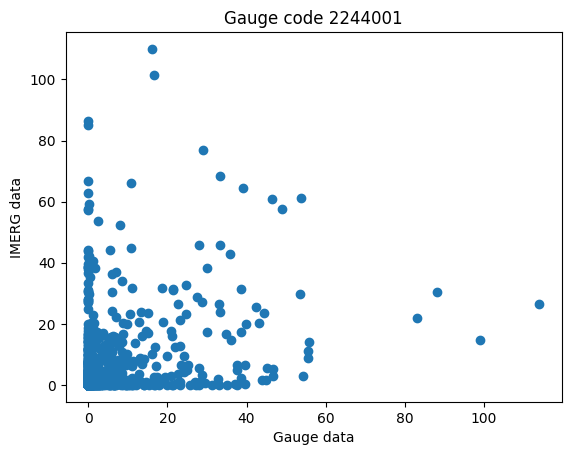

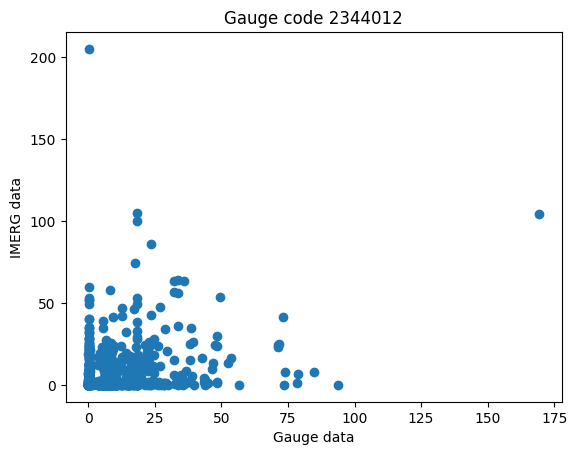

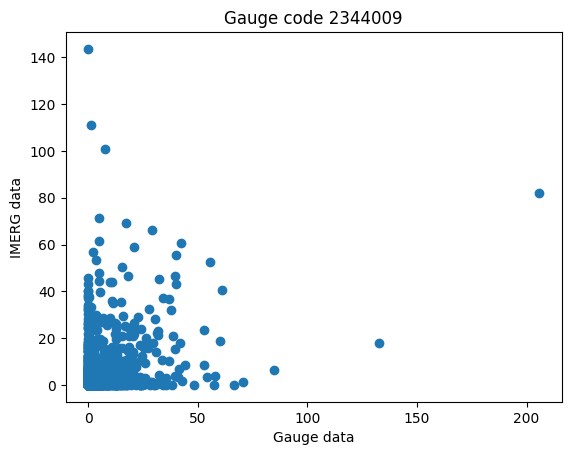

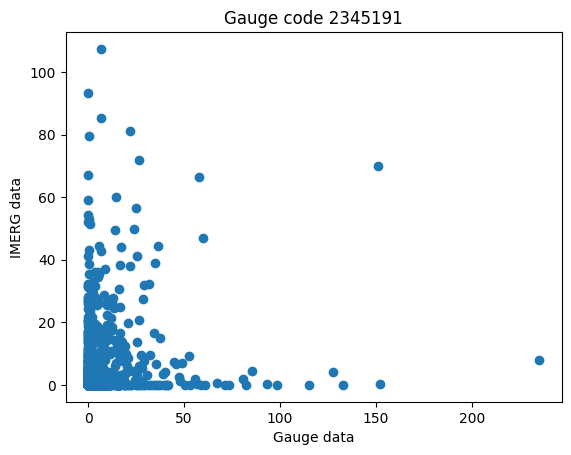

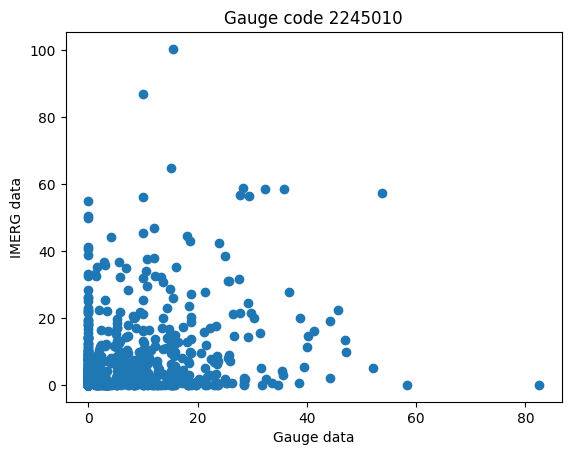

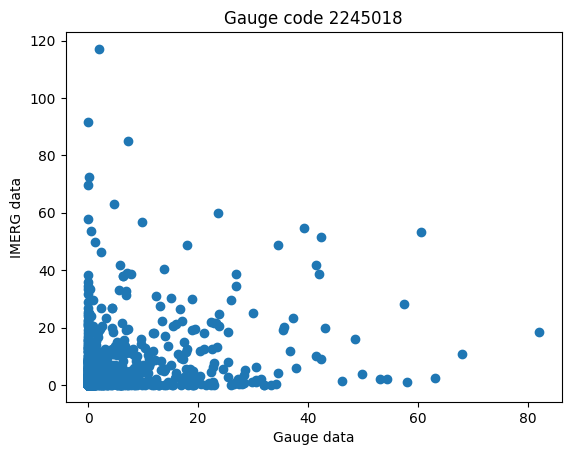

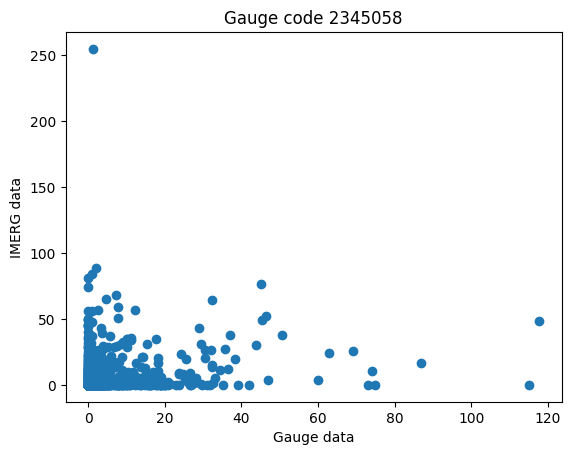

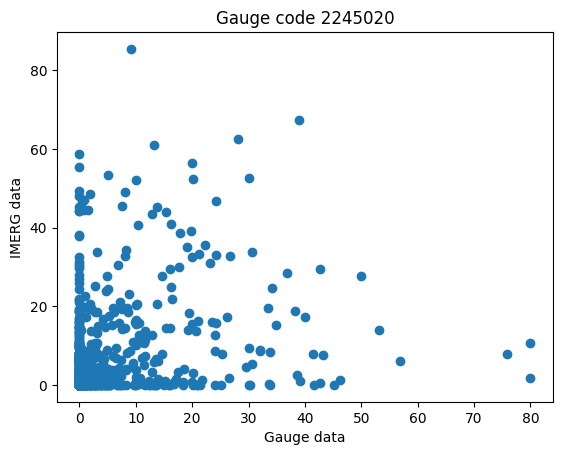

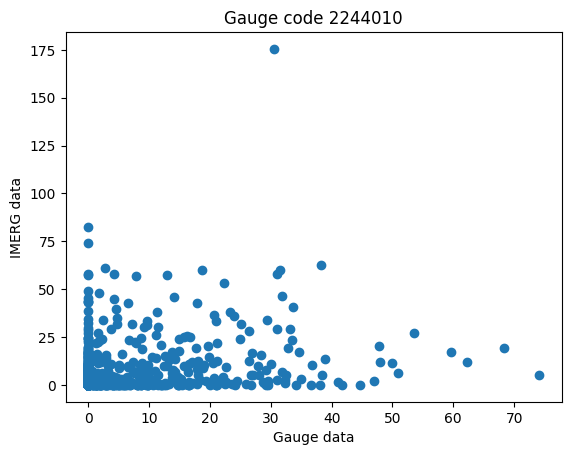

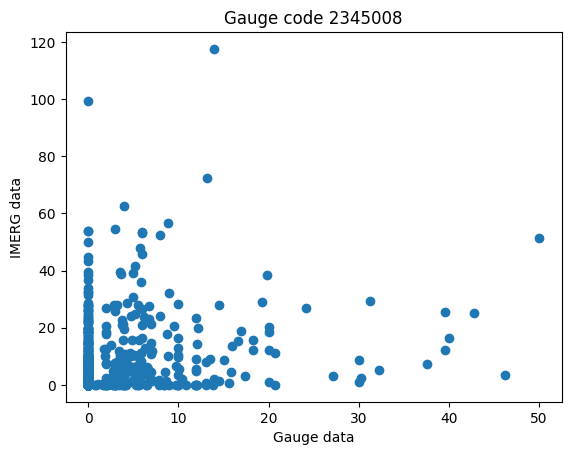

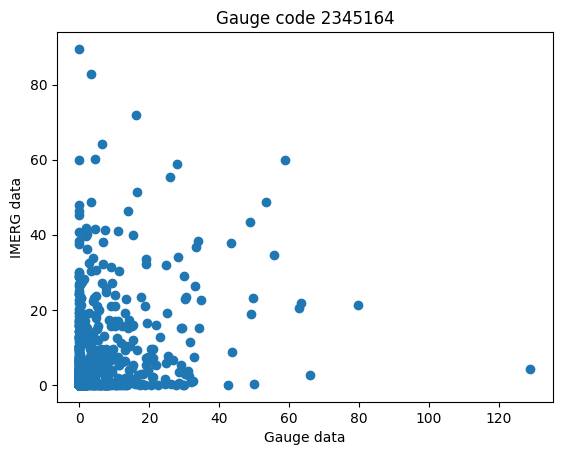

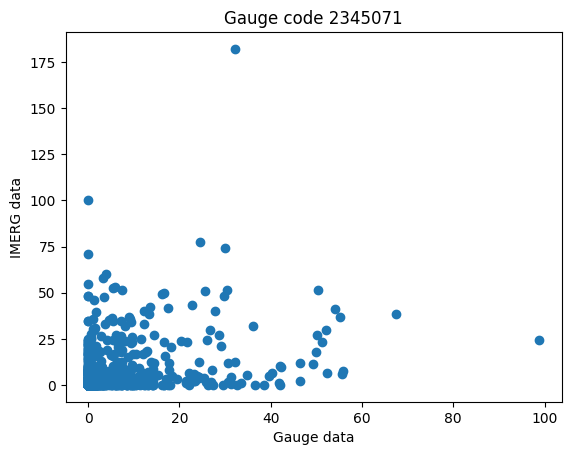

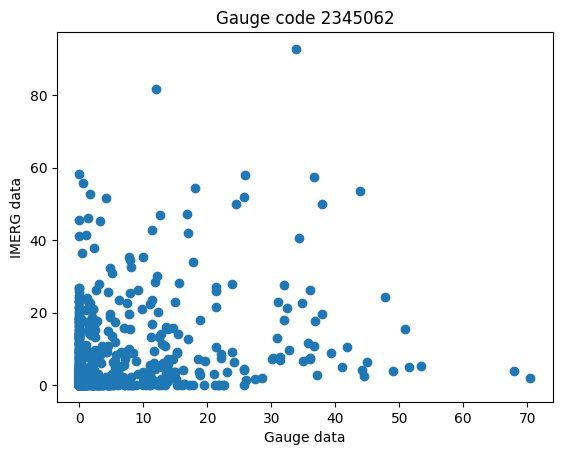

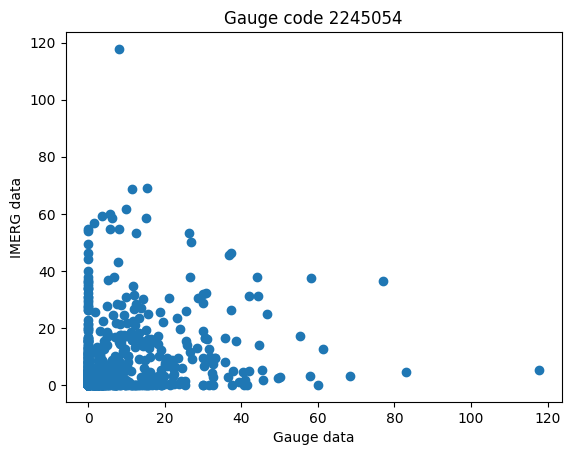

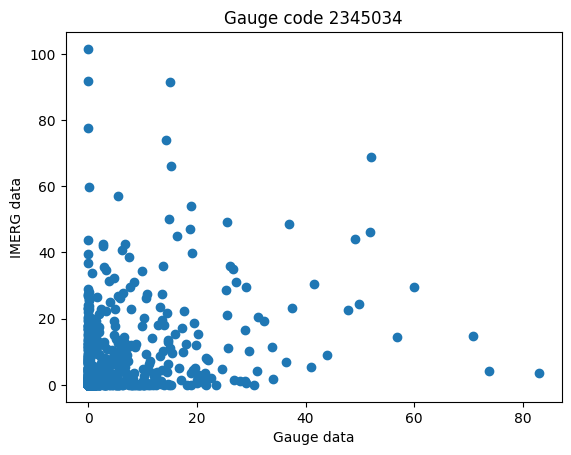

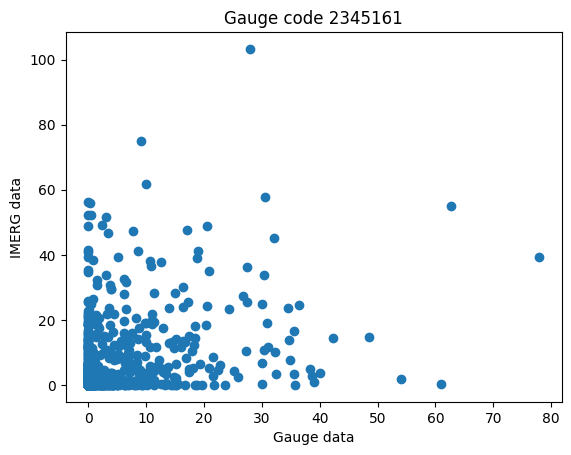

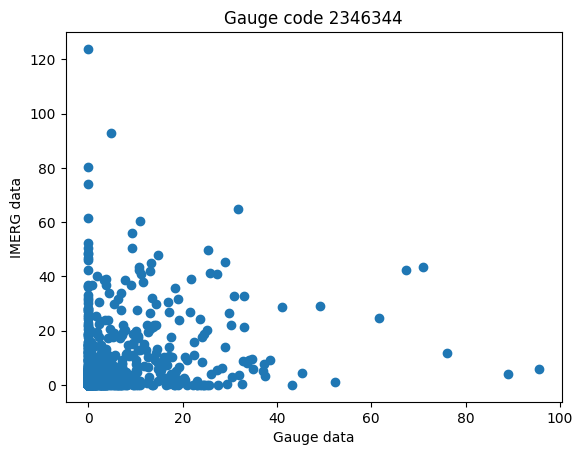

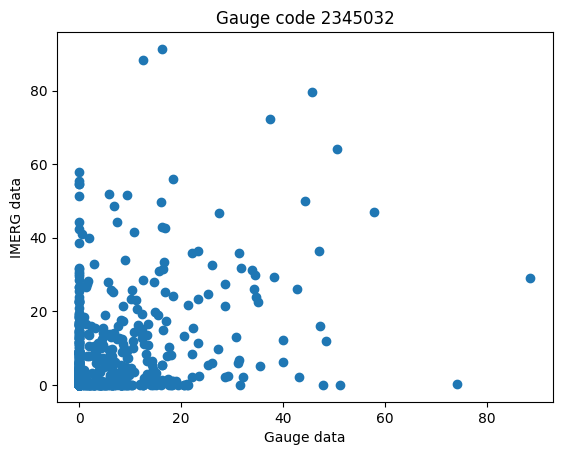

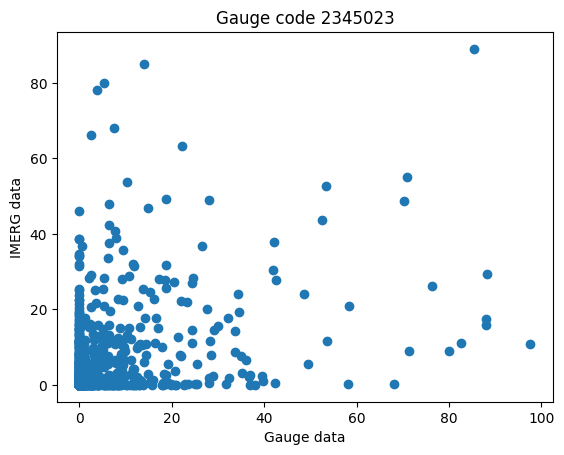

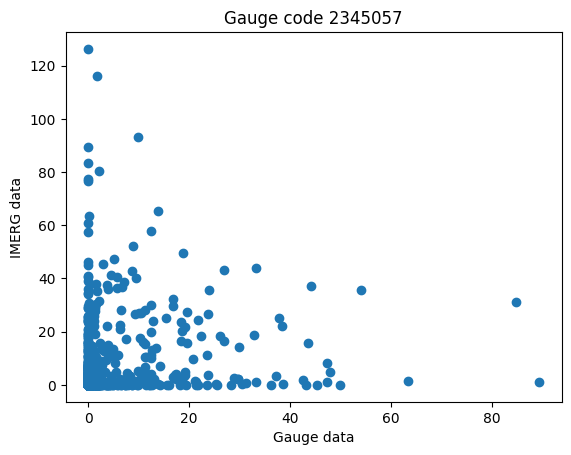

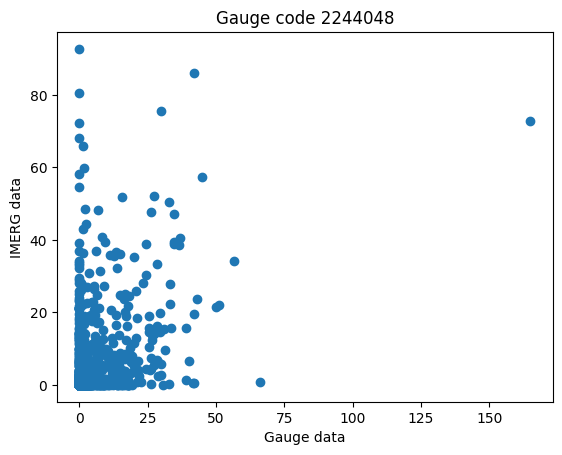

In [ ]:
# Plotting IMERG Scatter plot
# https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']

satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/IMERG/IMERGDC/imergDConcat.csv').set_index('Data')
gauge = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
gauge = gauge.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
gauge.columns = gauge.columns.str[1:]
df = gauge.join(satelite, rsuffix='s')

df = gauge.join(satelite, rsuffix='s')

for c in codes:
  df[[c, c+'s']]
  df = df.dropna(axis=0, how='any')
  plot = plt.scatter(df[c], df[c+'s'])    #plt.scatter(x,y)
  plt.title('Gauge code '+c)
  plt.xlabel('Gauge data')
  plt.ylabel('IMERG data')
  plt.show(plot)

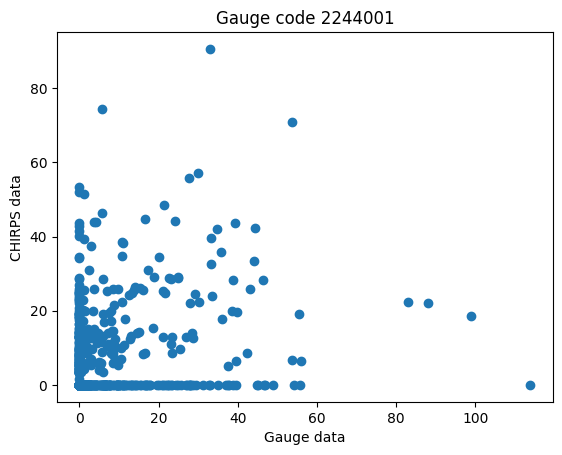

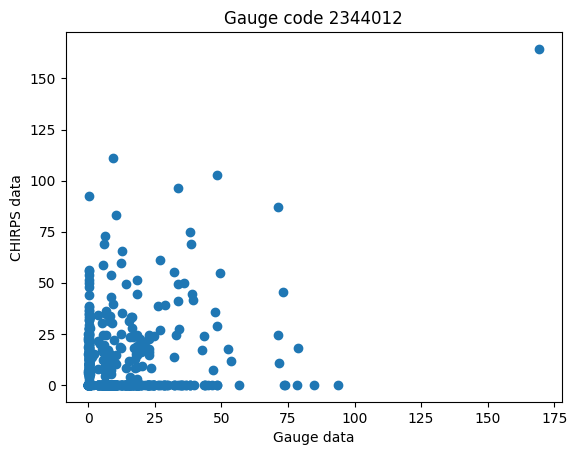

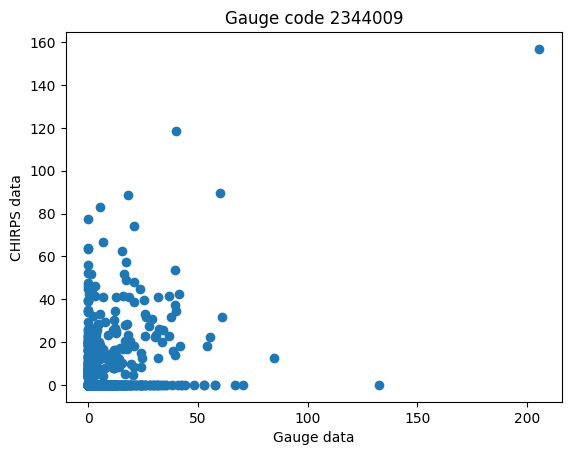

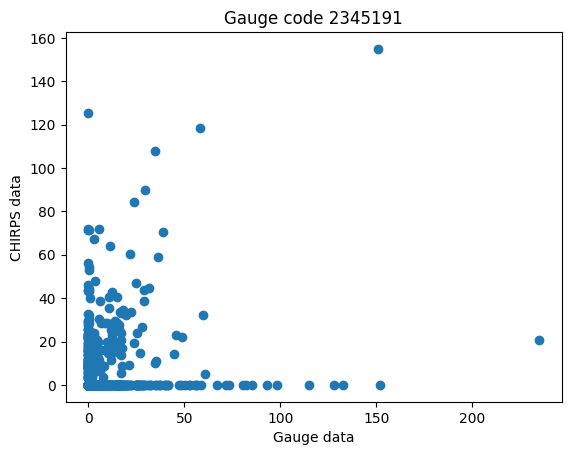

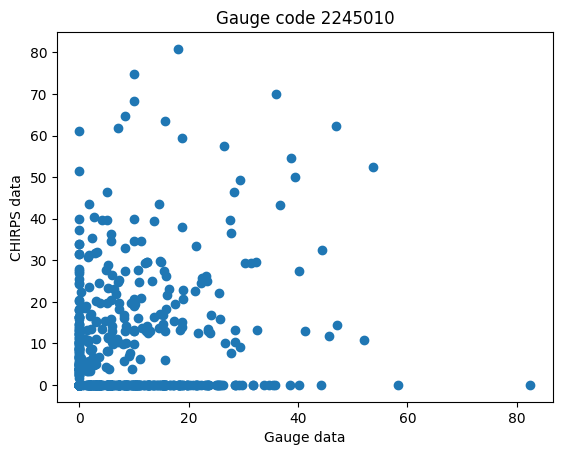

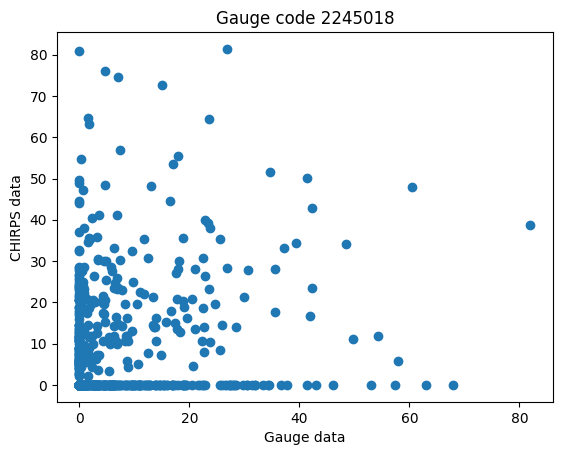

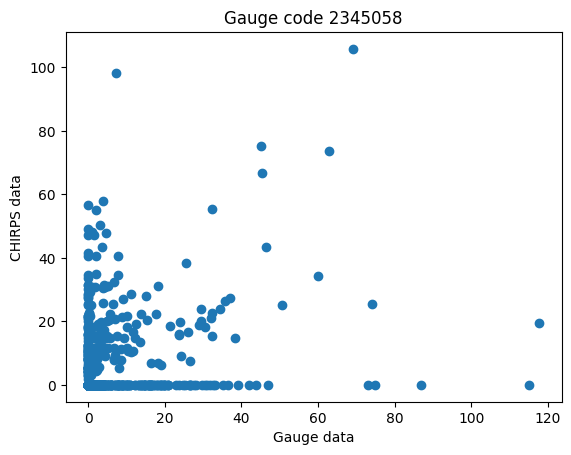

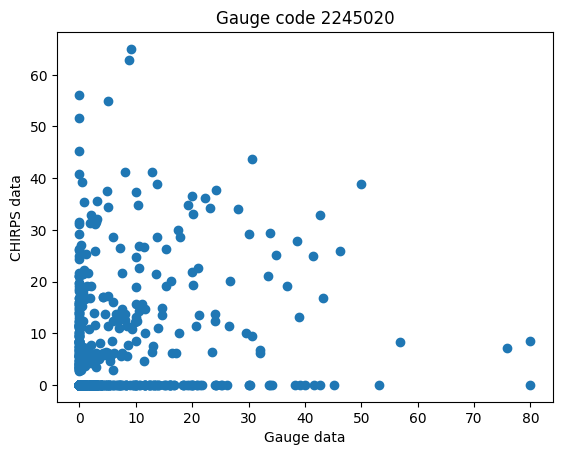

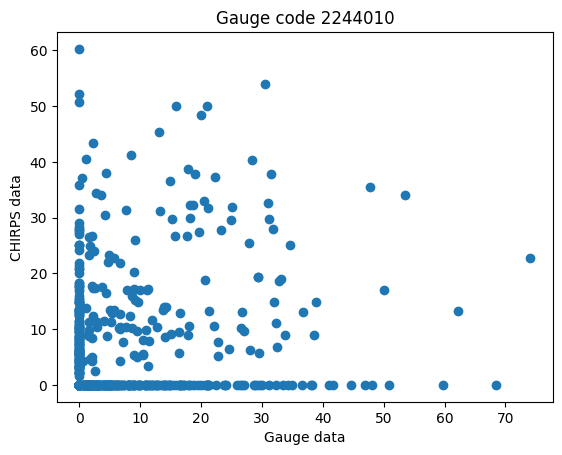

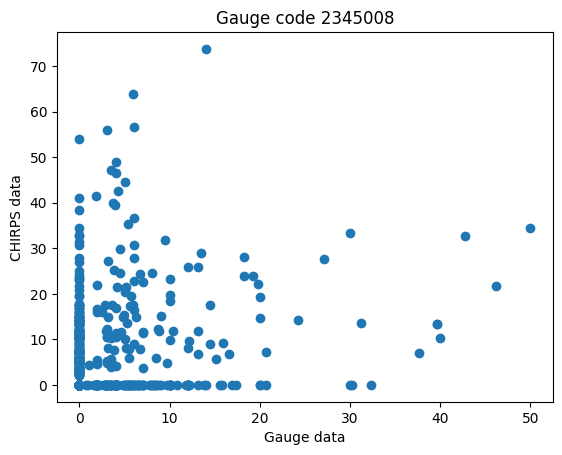

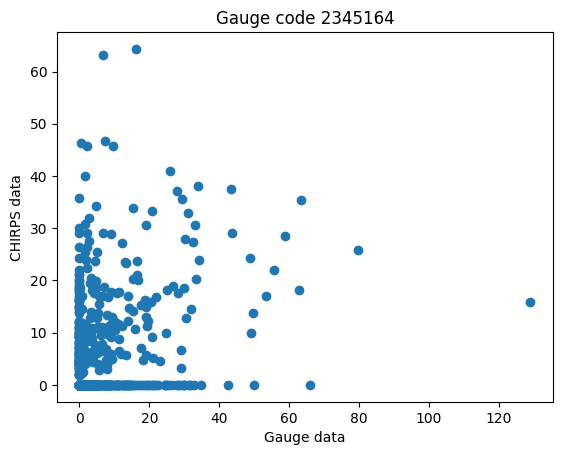

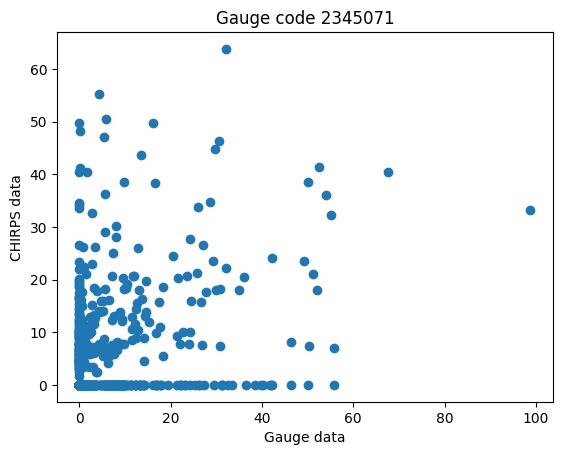

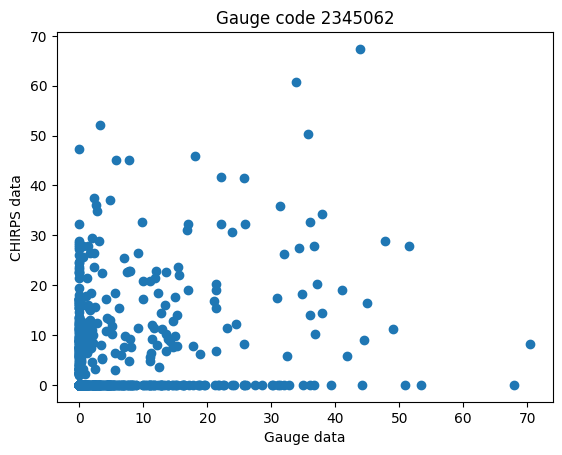

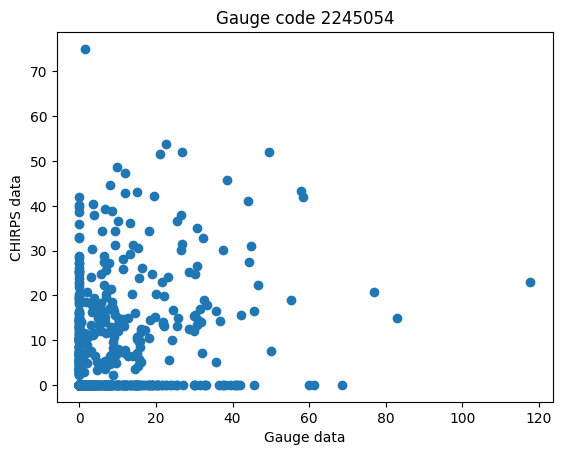

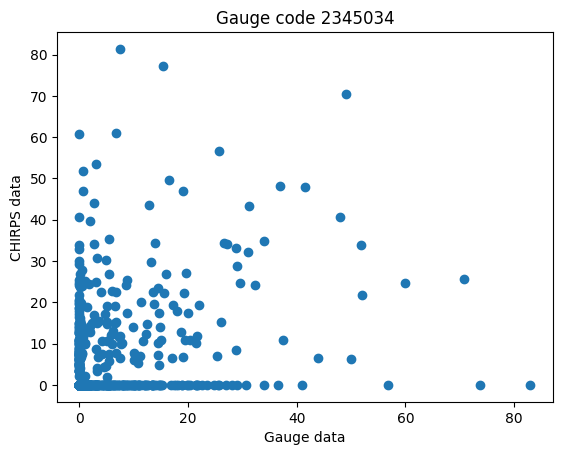

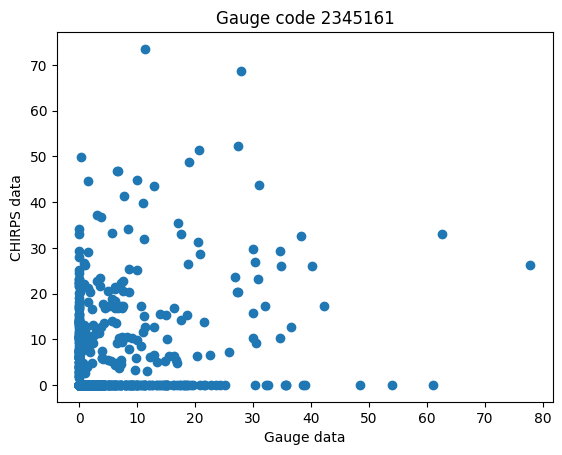

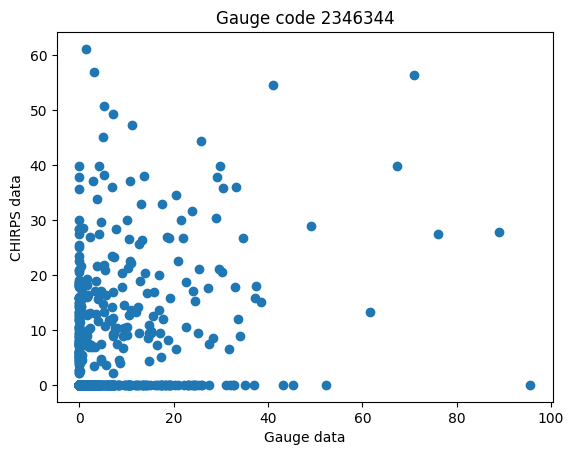

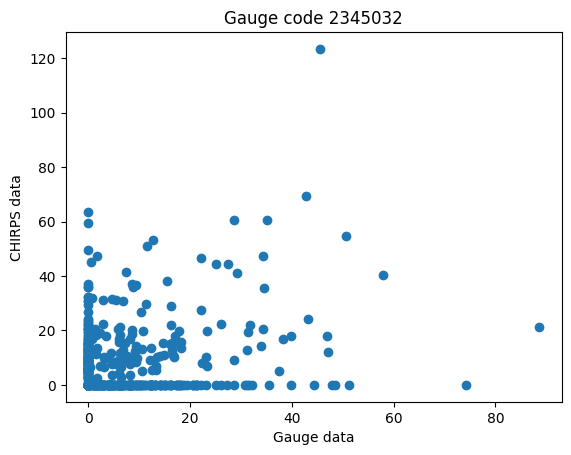

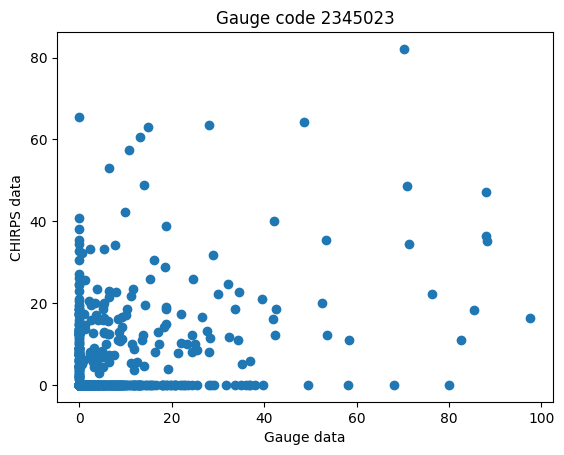

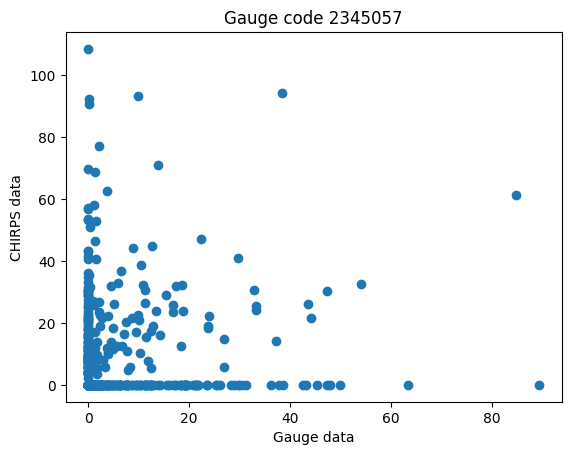

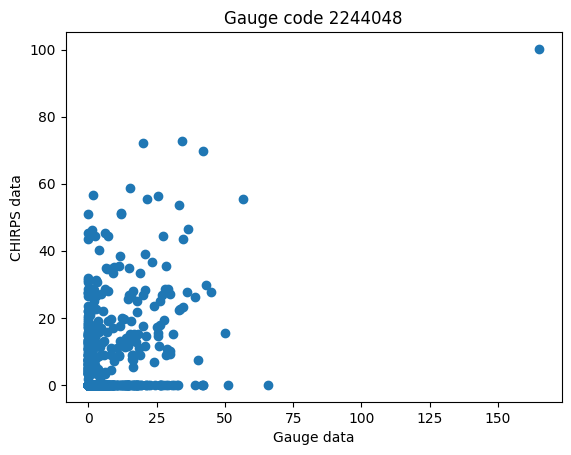

In [ ]:
# Plotting CHIRPS Scatter plot
# https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html#sphx-glr-gallery-shapes-and-collections-scatter-py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

codes = ['2244001', '2344012', '2344009', '2345191', '2245010', '2245018', '2345058', '2245020', '2244010', '2345008', '2345164', '2345071', '2345062', '2245054', '2345034', '2345161', '2346344', '2345032', '2345023', '2345057', '2244048']


satelite = pd.read_csv('/content/drive/MyDrive/DOC/DATA/Estacoes/VALIDACAO/CHIRPS/CHIRPSDC/chirpsDConcat.csv').set_index('date')

gauge = pd.read_csv('/content/drive/MyDrive/DOC/DATA/ANA/raindata30.csv')
gauge = gauge.rename(columns={'Unnamed: 0':'Data'}).set_index('Data')
gauge.columns = gauge.columns.str[1:]
df = gauge.join(satelite, rsuffix='s')
df

for c in codes:
  df[[c, c+'s']]
  df = df.dropna(axis=0, how='any')
  plot = plt.scatter(df[c], df[c+'s'] )    #plt.scatter(x,y)
  plt.title('Gauge code '+c)
  plt.xlabel('Gauge data')
  plt.ylabel('CHIRPS data')
  plt.show(plot)